<a href="https://colab.research.google.com/github/kslote1/shred/blob/main/Shred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


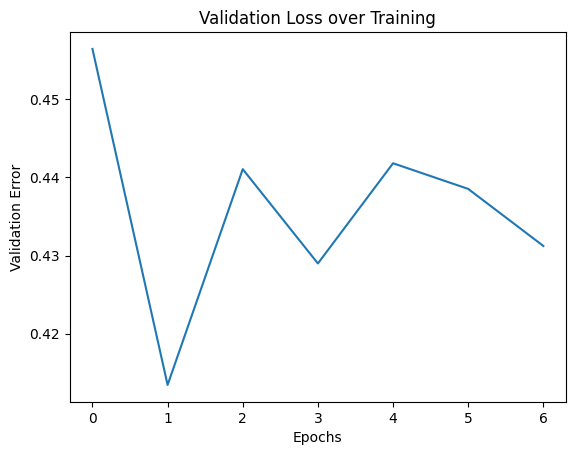

Model saved to shred_model.pth


In [1]:
import argparse
import torch
import numpy as np
import os
import scipy.linalg
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.len

def qr_place(data_matrix, num_sensors):
    u, s, v = np.linalg.svd(data_matrix, full_matrices=False)
    rankapprox = u[:, :num_sensors]
    q, r, pivot = scipy.linalg.qr(rankapprox.T, pivoting=True)
    return pivot[:num_sensors], rankapprox


class SHRED(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1):
        super(SHRED, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                  num_layers=hidden_layers, batch_first=True)
        self.linear1 = torch.nn.Linear(hidden_size, l1)
        self.linear2 = torch.nn.Linear(l1, l2)
        self.linear3 = torch.nn.Linear(l2, output_size)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        h_0 = torch.zeros((2, x.size(0), 64), dtype=torch.float).to(device)
        c_0 = torch.zeros((2, x.size(0), 64), dtype=torch.float).to(device)
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out[-1].view(-1, 64)
        output = torch.relu(self.linear1(h_out))
        output = torch.relu(self.linear2(self.dropout(output)))
        return self.linear3(self.dropout(output))


def fit(model, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, patience=5):
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    val_error_list = []
    best_params = model.state_dict()
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        for data in train_loader:
            model.train()
            optimizer.zero_grad()
            loss = criterion(model(data[0]), data[1])
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            model.eval()
            val_error = torch.linalg.norm(model(valid_dataset.X) - valid_dataset.Y) / torch.linalg.norm(valid_dataset.Y)
            val_error_list.append(val_error.item())

        if val_error == min(val_error_list):
            best_params = deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter == patience:
            model.load_state_dict(best_params)
            break

    return val_error_list



data_path = "/content/drive/MyDrive/data/E3Data.mat"
e3data = sio.loadmat(data_path)
X = e3data['X1']
df = pd.DataFrame(X,
    columns=[f"{column_index}" for column_index in range(120)]
)

num_sensors = 60
lags = 100

n, m = X.shape
train_indices = np.arange(0, int(n*0.85))
valid_indices = np.arange(int(n*0.85), n - lags)

sensor_locations, U_r = qr_place(X[train_indices].T, num_sensors)
sc = MinMaxScaler().fit(X[train_indices])
transformed_X = sc.transform(X)

all_data_in = np.array([transformed_X[i:i+lags, sensor_locations] for i in range(n - lags)])

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)

train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)

# Train Model
shred_model = SHRED(num_sensors, m).to(device)
val_errors = fit(shred_model, train_dataset, valid_dataset)

# Plot Validation Loss
plt.plot(val_errors)
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.title('Validation Loss over Training')
plt.show()

# Save Model
model_path = 'shred_model.pth'
torch.save(shred_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

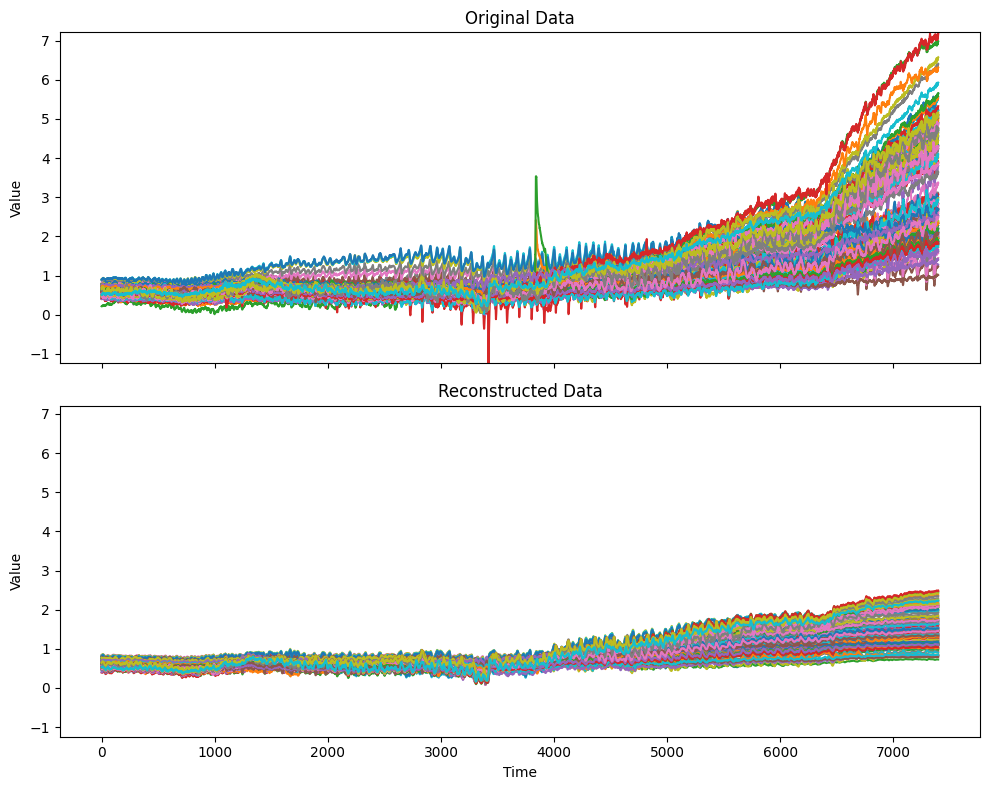

In [2]:
import matplotlib.pyplot as plt


# Convert tensors to numpy arrays
original_data = valid_data_out.cpu().numpy()
reconstructed_data = shred_model(valid_data_in).detach().cpu().numpy()


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot original data
axes[0].plot(original_data, linestyle='solid', label='Original')
axes[0].set_ylabel('Value')
axes[0].set_title('Original Data')
#axes[0].legend()

# Plot reconstructed data
axes[1].plot(reconstructed_data, label='Reconstructed')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].set_title('Reconstructed Data')
#axes[1].legend()

axes[0].set_ylim([min(original_data.min(), reconstructed_data.min()), max(original_data.max(), reconstructed_data.max())])
axes[1].set_ylim(axes[0].get_ylim())  # Ensure both have the same limits

# Adjust layout and show plot
plt.tight_layout()
plt.show()